# **Vehicle Detection Project**
Objective of this project is to detect the cars in a video from a front-facing camera on a car, using **Computer Vision** and **Machine learning** techniques.
The project involves two distinct steps:
*  Train a classifier to detect the presence of a vehicle using a labeled training set of images. This is split in two steps:
	* Extract features from the image using Computer Vision techniques, like Histogram of Oriented Gradients (HOG).
	* Train a classifier. Here we used Linear SVM.
* Detect vehicles in an image using previously trained classifier. 
	* This is done by implementing a sliding-window approach to split image into small batches of different sizes where we search for vehicle using previously trained classifier
	* Build a heat map of vehicle detections so as to reject outliers 
	* Draw bounding box for detected vehicles
    
**Note: This jupyter notebook works only on images. A different script exists for processing videos.**

In [1]:
# import modules and functions

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from pipeline_functions import *

### EXTRACT FEATURES AND TRAIN CLASSIFIER
To have the next cell work, you need to download image data sets (vehicles and non-vehicles) and put them in two distinct directories named *./vehicles* and *./non-vehicles*.
The ones that were used for this project can be downloaded at the following URLs:
- Vehicles: https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles_smallset.zip
- Non-vehicles: https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip

YOU CAN SKIP THIS CELL BECAUSE CLASSIFIER PARAMETERS ARE LOADED IN THE NEXT CELL
Image size is (64,64)

In [3]:
# Read in cars and notcars images
cars = glob.glob('.\\vehicles\\*\\*.png')
notcars = glob.glob('.\\non-vehicles\\*\\*.png')

# If you want to reduce data set size so as to reduce training time, change value of sample_size
sample_size = None
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

# Feature extraction
# Three types of features may be extracted:
# 1) raw pixel values: set 'spatial_feat' to True to extract this feature
#    parameters:
#   - color_space[0]: color conversion
#   - spatial_size: input image is resized to (spatial_size,spatial_size) 
#   -> nb of features: 3*spatial_size**2 
# 2) histogram of colors (one for each channel): set 'hist_feat' to True to extract this feature
#    parameters: 
#   - color_space[1]: color conversion
#   - hist_bins: nb of histogram bins (between 0 and 256)
#   -> nb of features: 3*hist_bins
# 3) histogram of gradient (one for each channel): set 'hist_feat' to True to extract this feature
#    parameters: 
#   - color_space[2]: color conversion
#   - orient: nb of histogram bins
#   - pix_per_cell: nb of pixels (identical for x and y) per cell
#   - cell_per_block: nb of cells per block (pixels values are standardized per block before HOG is computed)
#   - hog_channels: id of channel for which to compute HOG 
#   -> nb of features: nb_channels*((64/pix_per_cell)- cell_per_block + 1)^2*cell_per_block*orient

color_space = ['LUV','LUV','LUV'] # Color conversion for each of the free features to extract:
                      # (spatial,color hist, hog). Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# Spatial parameters
spatial_feat = True # Spatial features on or off
spatial_size = (16, 16) # Spatial binning dimensions
# Color histogram parameters
hist_feat = True # Histogram features on or off
hist_bins = 16    # Number of histogram bins for color
# HOG parameters
hog_feat = True # HOG features on or off
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 1 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Check the training time for the SVC
t=time.time()

# Parameter Tuning and classifier training
tune = 0
if tune == 1:
    parameters = {'kernel':('linear', 'rbf'), 'C':[0.001, 0.01,0.1], 'gamma':[0.02,0.1,0.5]}
    svr = SVC()
    svc = GridSearchCV(svr, parameters)
    svc.fit(X_train, y_train)
    print('Param:',svc.best_params_)
else:
    svc = LinearSVC(C=0.001)
    svc.fit(X_train, y_train)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to tune SVC parameters...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

#%% save data
pickle_file = "./param/svc_pickle.p"
import pickle
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["color_space"] = color_space
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["hog_channel"] = hog_channel
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins
dist_pickle["spatial_feat"] = spatial_feat
dist_pickle["hist_feat"] = hist_feat
dist_pickle["hog_feat"] = hog_feat
pickle.dump( dist_pickle, open(pickle_file, "wb" ) )

C:\Users\thomas\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 8 orientations 8 pixels per cell and 1 cells per block
Feature vector length: 2352
2.21 Seconds to tune SVC parameters...
Test Accuracy of SVC =  0.9941


### DETECT VEHICLES IN IMAGE
Here we implement sliding window technique.

C:\Users\thomas\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


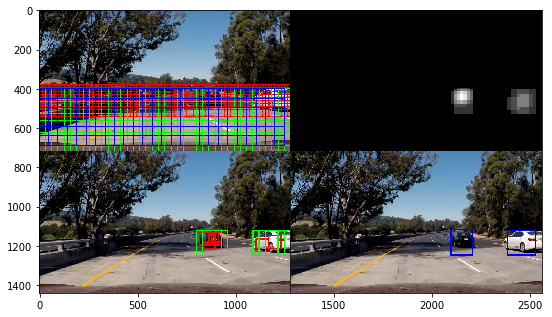

In [11]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pipeline_functions import *
from scipy.ndimage.measurements import label

pickle_file = "./param/svc_pickle16.p"

# load classifier and feature extraction parameters
dist_pickle = pickle.load( open(pickle_file, "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
color_space = dist_pickle["color_space"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
hog_channel = dist_pickle["hog_channel"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
spatial_feat = dist_pickle["spatial_feat"]
hist_feat = dist_pickle["hist_feat"]
hog_feat = dist_pickle["hog_feat"]

# input image
image = cv2.imread('images/test5.jpg')   # BGR image!
# Min and max in y to search in slide_window()
y_start_stop_list = [[380, 550],[400, None],[400, None],[400, None]]
# Scale factor for detection window: size = (64*scale,64*scale): 
scale_list = [1,2,3]#[0.5,1,2,3,4]
# Rectangle colors 
color_list = [(255,0,0),(0,255,0),(0,0,255),(255,255,0)]
# window overlap
overlap = 0.75

windows_ = []
hot_windows_ = []
image_RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
draw_image = np.copy(image_RGB)
draw_image_hot = np.copy(image_RGB)
for scale,y_start_stop,color in zip(scale_list,y_start_stop_list,color_list):
    windows, hot_windows = find_cars(image, y_start_stop, scale, overlap, svc, X_scaler, color_space, orient,
                    pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins,spatial_feat,hist_feat,hog_feat)
    windows_+=windows
    hot_windows_+=hot_windows
    # draw all windows / hot windows only
    draw_image = draw_boxes(draw_image, windows, color=color, thick=3)   
    draw_image_hot = draw_boxes(draw_image_hot, hot_windows, color=color, thick=6)   
                 
#%% create heat map
heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,hot_windows_)
# Apply threshold to help remove false positives
heat_thr = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat_thr, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image_RGB), labels)

# Draw figure with 4 subplots:
# windows, hot windows, heat map, final detection
p1 = np.concatenate((draw_image,draw_image_hot),0)
p2 = np.dstack((heatmap,heatmap,heatmap))/np.max(heatmap)*255
p2 = np.concatenate((p2,draw_img),0)
p =  np.concatenate((p1,p2.astype(np.uint8)),1)
#cv2.putText(p,'Hot windows',(50,10),cv2.FONT_HERSHEY_SIMPLEX, 3, [255,255,255])
#cv2.putText(p,'Heatmap',(1000,10),cv2.FONT_HERSHEY_SIMPLEX, 3, [255,255,255])
#cv2.putText(p,'Detected vehicles',(10,800),cv2.FONT_HERSHEY_SIMPLEX, 3, [255,255,255])
#cv2.putText(p,'Filtered heatmap',(10,800),cv2.FONT_HERSHEY_SIMPLEX, 3, [255,255,255])
fig = plt.figure(figsize=(9,7))
plt.imshow(p)
